# Lesson 1 - Exercise - lets help detect cancer!

Using lesson one from fast.ai mooc (https://course.fast.ai/) to have a crack at https://www.kaggle.com/c/histopathologic-cancer-detection/overview

Set up based on https://course.fast.ai/start_gcp.html

Standard commands for the top of any good notebook

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 180

Autosaving every 180 seconds


We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

Upload your Kaggle API key - Visit www.kaggle.com ⇨ login ⇨ My Account ⇨ Create New API Token

https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166


Install and setup the Kaggle API (Example below is for GCP)

SSH onto the host running the notebook

Upload the kaggle.json file to the host via the browser ssh.  (Click the cog in top right to get the menu option for uploading files.)

Download the kaggle dataset to google drive

pip install -q kaggle --user

vi ~/.profile

Add your user bin directory to your path (line I added looked like this)
PATH="/home/finlay_macrae/.local/bin:$PATH"

source ~/.profile

mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json  # set permission

kaggle competitions download -c histopathologic-cancer-detection -p ~/kaggle/cancer

*Now* unzip the files and fix the missing .tif on the labels.csv

cd ~/kaggle/cancer
unzip -qu train.zip -d train/ 
unzip -qu test.zip -d test/ 
unzip -qu sample_submission.csv.zip 
unzip -qu train_labels.csv.zip
chmod 644 train_labels.csv
mv train_labels.csv train/train_labels.csv
cat train/train_labels.csv | sed 's/,/.tif,/g' > train/labels.csv

Also create a models directory for jupyter

mkdir ~/kaggle/cancer/train/models
sudo chown jupyter ~/kaggle/cancer/train/models

Might be able to avoid some of the chowns etc if you just login as jupyter but I prefer having my files owned by my account when possible.


## Looking at the data

Description of the data can be found here:  https://www.kaggle.com/c/histopathologic-cancer-detection/data

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in a csv for only the training data.  Its called train_labels.csv and contains the image name and the label - 0 or 1.  I moved and renamed the file to just labels.csv and put it in the train directory as that's the default for fastai.  

In [4]:
path_test = Path('/home/finlay_macrae/kaggle/cancer/test')
path_train = Path('/home/finlay_macrae/kaggle/cancer/train')


fnames = get_image_files(path_train)
fnames[:5]

[PosixPath('/home/finlay_macrae/kaggle/cancer/train/ce2143e6b83ebb92123a3338189db3291a2a7002.tif'),
 PosixPath('/home/finlay_macrae/kaggle/cancer/train/bd252234bee202c6e3cf11c4ed7b4ba29f587bb7.tif'),
 PosixPath('/home/finlay_macrae/kaggle/cancer/train/e3d592d111f93c4f2519c06b5b2ce51a6aab2913.tif'),
 PosixPath('/home/finlay_macrae/kaggle/cancer/train/fed4991f18da56841eca8c5898cc05fdae9263fa.tif'),
 PosixPath('/home/finlay_macrae/kaggle/cancer/train/694f3a607d8411f99f147bb98e084fec0c8b1e45.tif')]

In [6]:
np.random.seed(2)
label_path = Path('/home/finlay_macrae/kaggle/cancer/train/labels.csv')
df = pd.read_csv(label_path)
df.head()

,id.tif,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


Create a databunch to hold the inputs.
note the normalize at the end as this normalizes the inputs (best to do that on the set the original model was trained.  In this case imagenet)
Size is the size of the input images.  For us they are 96x96

In [7]:
data = ImageDataBunch.from_csv(path_train,  ds_tfms=get_transforms(), size=96, bs=bs).normalize(imagenet_stats)

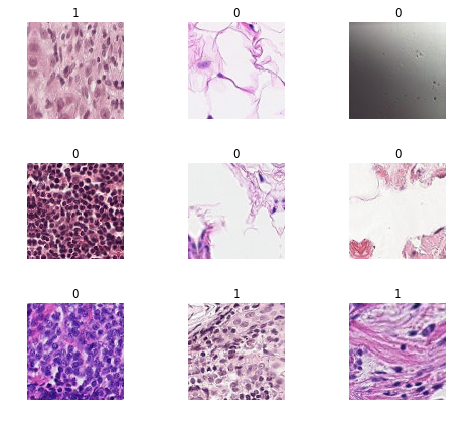

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [11]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.314959,0.263865,0.107079,06:13
1,0.246522,0.206996,0.079718,04:01
2,0.231676,0.183950,0.069992,03:59
3,0.210054,0.180709,0.069560,04:01


In [14]:
help(learn.save)

Help on method save in module fastai.basic_train:

save(file: Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO] = None, return_path: bool = False, with_opt: bool = True) method of fastai.basic_train.Learner instance
    Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)



In [15]:
project_path = Path('/home/finlay_macrae/kaggle/cancer/train/models')
path_model = project_path/'fastai-cancer-stage-1'

In [16]:
learn.save(path_model)

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

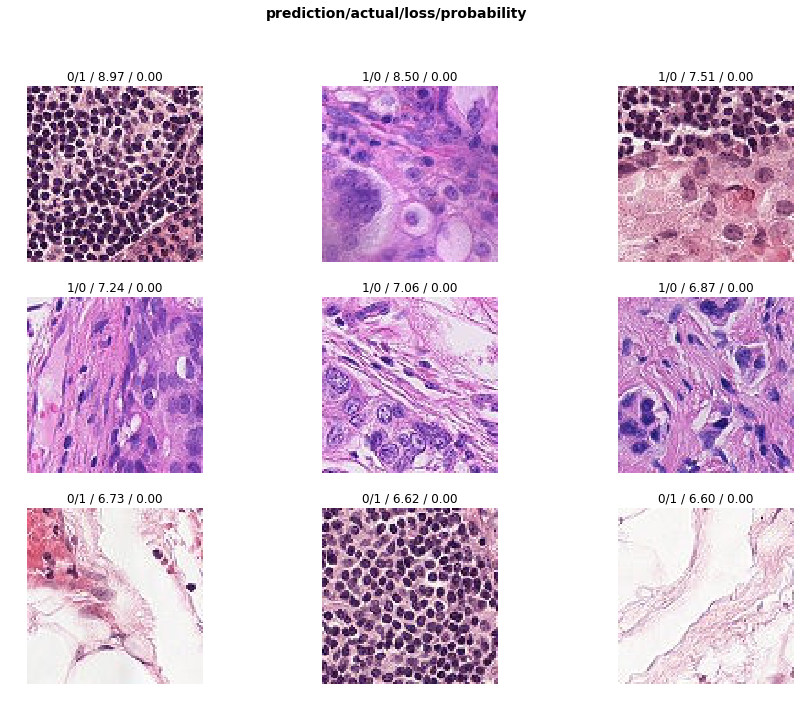

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
help(interp.plot_top_losses)

Help on method _cl_int_plot_top_losses in module fastai.vision.learner:

_cl_int_plot_top_losses(k, largest=True, figsize=(12, 12), heatmap: bool = True, heatmap_thresh: int = 16, return_fig: bool = None) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class.



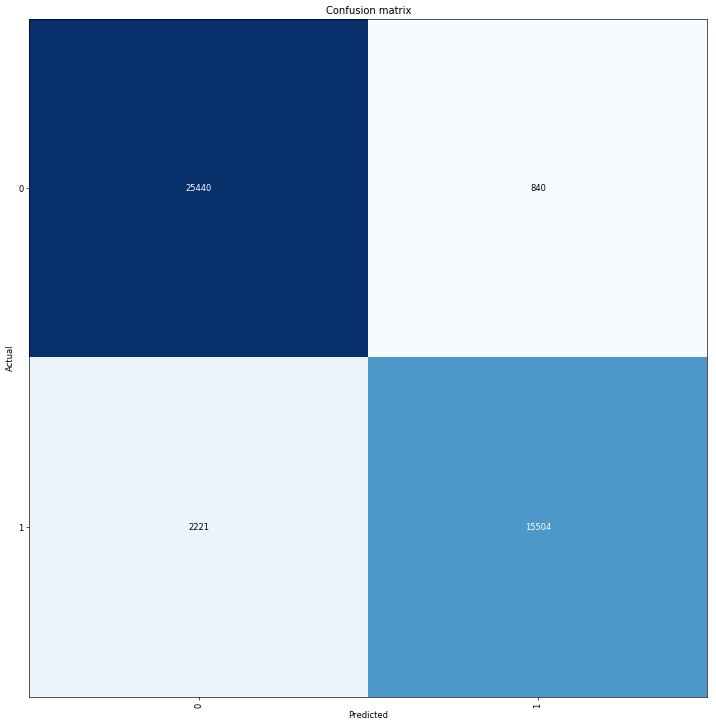

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[(1, 0, 2221), (0, 1, 840)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.163068,0.136756,0.049131,05:30


This worked ok so let's find out why

In [25]:
#no need to load the old model as this one was cooler
#learn.load(path_model);

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


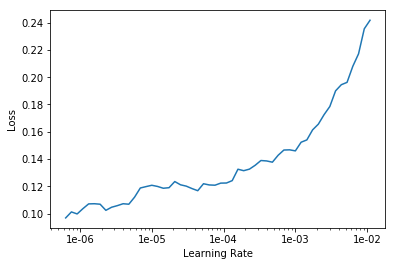

In [27]:
learn.recorder.plot()

In [53]:
for i in range(6):
    learn.fit_one_cycle(1)
    filename = 'fastai-cancer-stage-iteration-' + str(i)
    path_model = project_path/filename
    learn.save(path_model)
    print(filename)
    
    

epoch,train_loss,valid_loss,error_rate,time
0,0.073196,1.879645,0.039177,03:59


fastai-cancer-stage-iteration-0


epoch,train_loss,valid_loss,error_rate,time
0,0.072493,0.129031,0.036110,04:00


fastai-cancer-stage-iteration-1


epoch,train_loss,valid_loss,error_rate,time
0,0.074404,0.275793,0.035678,03:58


fastai-cancer-stage-iteration-2


epoch,train_loss,valid_loss,error_rate,time
0,0.081190,0.088672,0.031224,04:00


fastai-cancer-stage-iteration-3


epoch,train_loss,valid_loss,error_rate,time
0,0.081902,2.557723,0.038632,03:59


fastai-cancer-stage-iteration-4


epoch,train_loss,valid_loss,error_rate,time
0,0.075475,1.524390,0.039064,03:58


fastai-cancer-stage-iteration-5


That's a pretty accurate model!

In [52]:
path_model = project_path/'fastai-cancer-stage-3-5'
learn.load(path_model);

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


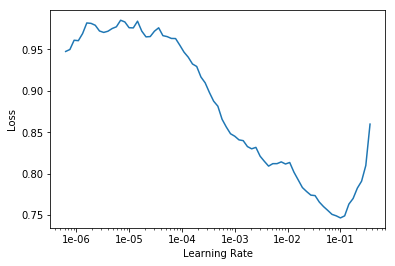

In [10]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(8, max_lr=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,0.313974,0.561612,0.207999,06:39
1,0.389341,0.302803,0.117169,06:35
2,0.509983,967.029724,0.155528,06:35
3,0.439720,14.864531,0.148619,06:34
4,0.378362,56.887150,0.131121,06:36
5,0.364501,415.786804,0.116237,06:36
6,0.297154,57.064835,0.118668,06:35
7,0.271617,0.239626,0.094148,06:36


In [32]:
path_model_res50 = project_path/'fastai-cancer-resnet50-iteration-1'
learn.save(path_model_res50)

resnet50 is a bit harder to train! Let's see if full fine-tuning helps:

In [33]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.274956,0.263779,0.095921,08:42
1,0.263100,0.315137,0.096512,08:40
2,0.274540,0.256134,0.095216,08:42


In [35]:
path_model_res50 = project_path/'fastai-cancer-resnet50-iteration-2'
learn.save(path_model_res50)

If it doesn't, you can always go back to your previous model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


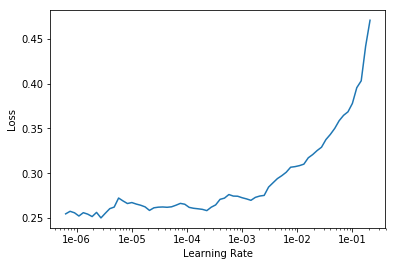

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.279428,0.360013,0.153255,08:40
1,0.242597,0.213341,0.085172,08:43
2,0.227727,0.181552,0.068220,08:42


In [38]:
learn.save(path_model_res50)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


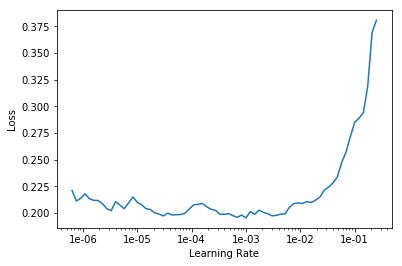

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(3, max_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.319695,0.676482,0.293989,08:42
1,0.251082,0.282251,0.121850,08:40
2,0.202610,0.191493,0.073355,08:40


Picked the wrong LR obviously from watching lesson 2 we should be picking Lr close to top of the last downwards drive, so maybe 1e-4 to 1e-2 would have worked better?

In [41]:
project_path = Path('/home/finlay_macrae/kaggle/cancer/train/models')
path_model_res50 = project_path/'fastai-cancer-resnet50-iteration-2'
learn.load(path_model_res50)
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


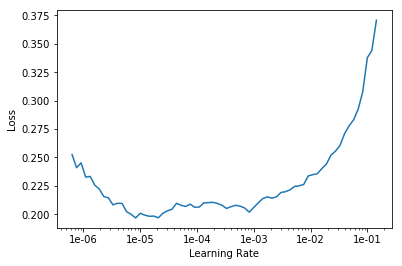

In [42]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(3, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.203621,0.179416,0.067515,06:33
1,0.210520,0.180822,0.068538,06:33
2,0.206456,0.181205,0.068765,06:33


In [46]:
learn.fit_one_cycle(3, max_lr=slice(1e-6, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.201200,0.179492,0.067629,08:41
1,0.201026,0.178541,0.067083,08:42
2,0.195916,0.180489,0.068197,08:42


In [47]:
learn.save(path_model_res50)

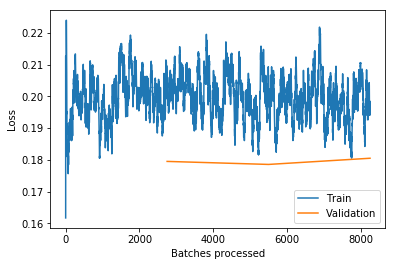

In [48]:
learn.recorder.plot_losses()

In [12]:
#load best resnet34
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
project_path = Path('/home/finlay_macrae/kaggle/cancer/train/models')
path_model_res34 = project_path/'fastai-cancer-stage-iteration-3'
learn.load(path_model_res34)


Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,0,0,1,1
Path: /home/finlay_macrae/kaggle/cancer/train;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,1,1
Path: /home/finlay_macrae/kaggle/cancer/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [24]:

#load best resnet50
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
project_path = Path('/home/finlay_macrae/kaggle/cancer/train/models')
path_model_res50 = project_path/'fastai-cancer-resnet50-iteration-2'
learn.load(path_model_res50)

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,0,0,1,1
Path: /home/finlay_macrae/kaggle/cancer/train;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,1,1
Path: /home/finlay_macrae/kaggle/cancer/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [15]:
import glob
import os
test_file_list = glob.glob('/home/finlay_macrae/kaggle/cancer/test/*.tif')
print(test_file_list[:5])



['/home/finlay_macrae/kaggle/cancer/test/d88165cf80b220030ed3bcbec3667b5b4acd4618.tif', '/home/finlay_macrae/kaggle/cancer/test/d818ce112aa5f8481c91f693a1cc1c503d407976.tif', '/home/finlay_macrae/kaggle/cancer/test/f8506674cfd7e22697fcbffc5d414043aa1773dd.tif', '/home/finlay_macrae/kaggle/cancer/test/74f41a1117a1b85b127fecf45647e001eaa5ddc8.tif', '/home/finlay_macrae/kaggle/cancer/test/e942d81a834435c5ba5cf9b84f91c913ba8c8b92.tif']


In [25]:
all_preds = []
for filename in test_file_list:
    img = open_image(filename)
    pred = learn.predict(img)
    all_preds.append(pred)

In [26]:
print(all_preds[:5])

[(Category 0, tensor(0), tensor([0.9717, 0.0283])), (Category 0, tensor(0), tensor([0.7260, 0.2740])), (Category 1, tensor(1), tensor([0.3095, 0.6905])), (Category 0, tensor(0), tensor([0.8642, 0.1358])), (Category 1, tensor(1), tensor([0.0023, 0.9977]))]


In [27]:
sub_dict = {pred[0] : pred[1][1].item() for pred in zip(test_file_list, all_preds)}

In [28]:
import pandas as pd
sub_df = pd.DataFrame.from_dict(sub_dict, orient='index', columns=['label'])
sub_df.index.name = 'id'
sub_df.head(5)

,label
id,
/home/finlay_macrae/kaggle/cancer/test/d88165cf80b220030ed3bcbec3667b5b4acd4618.tif,0
/home/finlay_macrae/kaggle/cancer/test/d818ce112aa5f8481c91f693a1cc1c503d407976.tif,0
/home/finlay_macrae/kaggle/cancer/test/f8506674cfd7e22697fcbffc5d414043aa1773dd.tif,1
/home/finlay_macrae/kaggle/cancer/test/74f41a1117a1b85b127fecf45647e001eaa5ddc8.tif,0
/home/finlay_macrae/kaggle/cancer/test/e942d81a834435c5ba5cf9b84f91c913ba8c8b92.tif,1


In [29]:
sub_df.to_csv('attempt2.csv')

Need to get the sample submission csv into right state:

sudo chmod 664 sample_submission.csv
sudo chown jupyter sample_submission.csv


Exporting the Model for use on Render

From the docs:

Once everything is ready for inference, we just have to call learn.export to save all the information of our Learner object for inference: the stuff we need in the DataBunch (transforms, classes, normalization...), the model with its weights and all the callbacks our Learner was using. Everything will be in a file named export.pkl in the folder learn.path. If you deploy your model on a different machine, this is the file you'll need to copy.

learn.export()
To create the Learner for inference, you'll need to use the load_learner function. Note that you don't have to specify anything: it remembers the classes, the transforms you used or the normalization in the data, the model, its weigths... The only argument needed is the folder where the 'export.pkl' file is.

learn = load_learner(path_train)

In [19]:
?learn.export

In [23]:
learn.export()